**Univariate Time Series Analysis**

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import sklearn.preprocessing
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

**Preparing Data**

In [38]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/hourly-energy-consumption/DOM_hourly.csv')
df.head()

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0


In [39]:
df.shape

(116189, 2)

In [40]:
# uncomment the following line for generating daily data
# df = df[df['Datetime'].str.contains("00:00:00")]

In [41]:
df['Datetime'] = pd.to_datetime(df.Datetime , format = '%Y-%m-%d %H:%M:%S')
df.index = df.Datetime
df.drop(['Datetime'], axis = 1,inplace = True)
df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


In [42]:
#checking missing data
df.isna().sum()

DOM_MW    0
dtype: int64

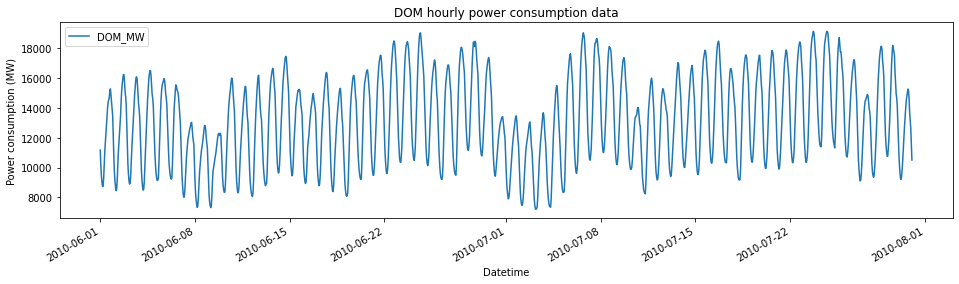

In [43]:
#@title Date Range
a = '2010-06-01'#@param {type:"date"}
b = '2010-07-31' #@param {type:"date"}
a = a+" 00:00:00"
b = b+" 00:00:00"
df.loc[a:b].plot(figsize = (16,4),legend = True)
plt.title('DOM hourly power consumption data')
plt.ylabel('Power consumption (MW)')
plt.show()

In [44]:
scaler = MinMaxScaler()
df['DOM_MW'] = scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))
df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,0.398863
2005-12-31 02:00:00,0.383224
2005-12-31 03:00:00,0.379841
2005-12-31 04:00:00,0.381851
2005-12-31 05:00:00,0.386263


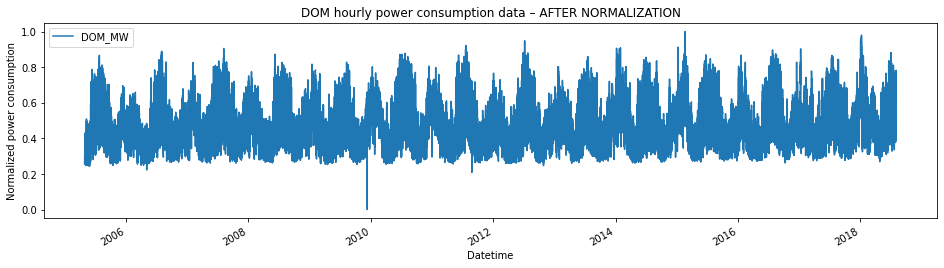

In [45]:
df.plot(figsize = (16,4), legend = True)
plt.title('DOM hourly power consumption data – AFTER NORMALIZATION')
plt.ylabel('Normalized power consumption')
plt.show()

**Creating Training/Testing Datasets**


In [46]:
def load_data(stock, seq_len):
  X_train = []
  y_train = []

  for i in range(seq_len, len(stock)):
    X_train.append(stock.iloc[i-seq_len : i, 0])
    y_train.append(stock.iloc[i, 0])

  X_test = X_train[int(0.9*(len(stock))):]
  y_test = y_train[int(0.9*(len(stock))):]
  X_train = X_train[:int(0.9*(len(stock)))]
  y_train = y_train[:int(0.9*(len(stock)))]

  # convert to numpy array
  X_train = np.array(X_train)
  y_train = np.array(y_train)
  X_test = np.array(X_test)
  y_test = np.array(y_test)

  # reshape data to input into RNN models
  X_train = np.reshape(X_train, (X_train.shape[0], seq_len, 1))
  X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
  
  return [X_train, y_train, X_test, y_test]

In [47]:
#create train, test data
seq_len = 20 #choose sequence length
X_train, y_train, X_test, y_test = load_data(df, seq_len)

In [48]:
print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (104570, 20, 1)
y_train.shape =  (104570,)
X_test.shape =  (11599, 20, 1)
y_test.shape =  (11599,)


**Creating Input Tensors**

In [49]:
batch_size = 256
buffer_size = 1000

In [50]:
train_data = tf.data.Dataset.from_tensor_slices((X_train , y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
test_data = tf.data.Dataset.from_tensor_slices((X_test , y_test))
test_data = test_data.batch(batch_size).repeat()

**Building Model**

In [51]:
rnn_model = tf.keras.models.Sequential(
    [
     tf.keras.layers.LSTM(8, input_shape =X_train.shape[-2:]),
     tf.keras.layers.Dense(1)
     ]
)

SyntaxError: ignored

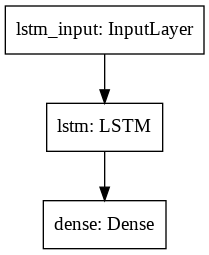

In [54]:
tf.keras.utils.plot_model(rnn_model)

In [55]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


**Compiling and Training**

In [56]:
rnn_model.compile(optimizer = 'adam', loss = 'mae')

In [57]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

rnn_model.fit(
    train_data, 
    epochs = EPOCHS, 
    steps_per_epoch = EVALUATION_INTERVAL,
    validation_data = test_data,
    validation_steps = 50
)

Epoch 1/10
200/200 [==============================] - 4s 10ms/step - loss: 0.0881 - val_loss: 0.0693
Epoch 2/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0600 - val_loss: 0.0582
Epoch 3/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0512 - val_loss: 0.0505
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0429 - val_loss: 0.0413
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0352 - val_loss: 0.0314
Epoch 6/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0276 - val_loss: 0.0271
Epoch 7/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0229 - val_loss: 0.0202
Epoch 8/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0215 - val_loss: 0.0207
Epoch 9/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0198 - val_loss: 0.0181
Epoch 10/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0191 - val_loss: 0.017

**Evaluation**

In [58]:
rnn_predictions = rnn_model.predict(X_test)

In [60]:
rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model ="+"{:.4f}".format(rnn_score))

R2 Score of RNN model =0.9541


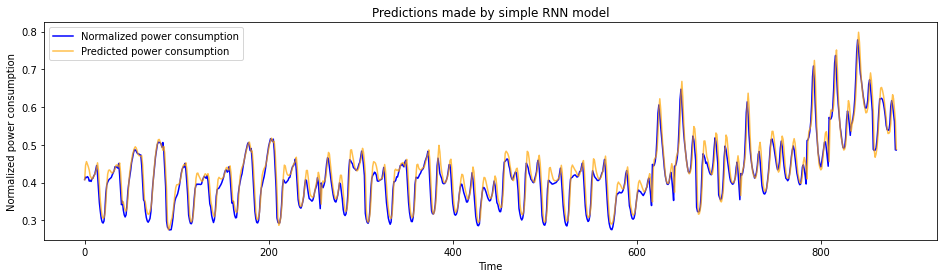

In [66]:
#@title Data Range
a = 3856 #@param {type:"slider", min:0, max:12000, step:1}
b = 4739 #@param {type:"slider", min:0, max:12000, step:1}

def plot_predictions(test, predicted, title):
  plt.figure(figsize = (16,4))
  plt.plot(
      test[a:b], 
      color = 'blue',
      label = 'Normalized power consumption'
  )
  plt.plot(
      predicted[a:b], 
      alpha = 0.7,
      color = 'orange',
      label = 'Predicted power consumption'
  )
  
  plt.title(title)
  plt.xlabel('Time')
  plt.ylabel('Normalized power consumption')
  plt.legend()
  plt.show()
  
plot_predictions(
      y_test, 
      rnn_predictions,
      "Predictions made by simple RNN model")

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


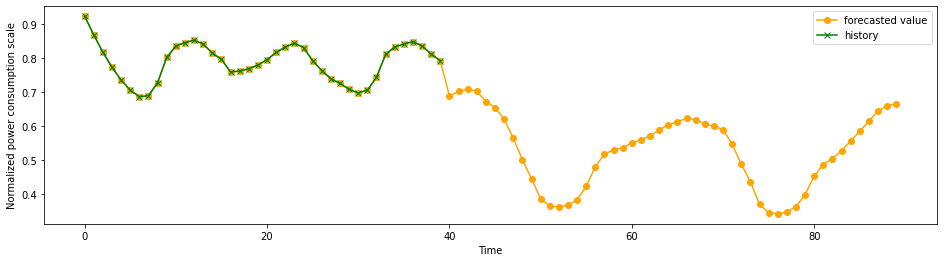

In [67]:
history_data = list(y_test[-40:])
plottingvalues = list(history_data) + list(rnn_predictions[:50])

plt.figure(figsize = (16,4))

plt.plot(plottingvalues, color = 'orange', label = 'forecasted value',marker = 'o')
plt.plot(y_test[-40:], color = 'green', label = 'history',marker = 'x')

plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()

**Predicting Next Data Point**

In [78]:
X = X_test[-1:]
rnn_predictions1 = rnn_model.predict(X)

In [79]:
rnn_predictions1

array([[0.8109228]], dtype=float32)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


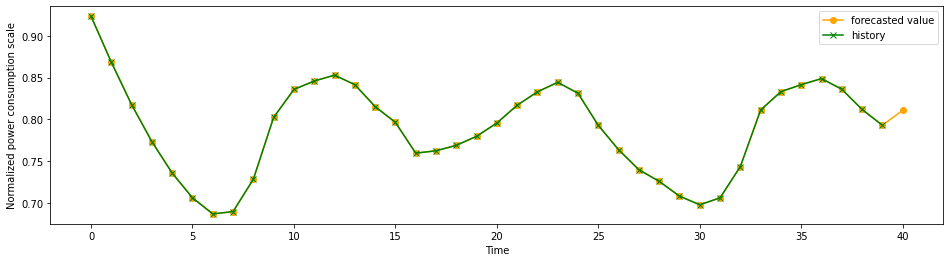

In [83]:
history_data = list(y_test[-40:])
plottingvalues = list(history_data) + list(rnn_predictions1)

plt.figure(figsize = (16,4))

plt.plot(plottingvalues, color = 'orange', label = 'forecasted value',marker = 'o')
plt.plot(y_test[-40:], color = 'green', label = 'history',marker = 'x')

plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()

**Predicting Range of Data Points**

In [87]:
history_data = list(y_test[-40:])

In [88]:
def make_data(X , rnn_predictions1):
  val = list(X[0][1:]) + list(rnn_predictions1)
  X_new = []
  X_new.append(list(val))
  X_new = np.array(X_new)
  return X_new

In [89]:
forecast = list()

In [90]:
X = X_test[-1:]

In [91]:
for i in range (25):
  X = make_data(X,rnn_predictions1)
  rnn_predictions1 = rnn_model.predict(X)
  forecast += list(rnn_predictions1)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


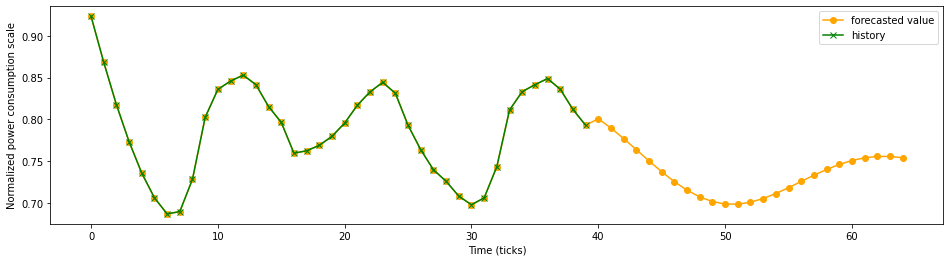

In [93]:
plottingvalues = list(history_data)+list(forecast)

plt.figure(figsize=(16,4))

plt.plot(plottingvalues, color = 'orange',label = 'forecasted value',marker = 'o')
plt.plot(y_test[-40:], color = 'green',label = 'history',marker = 'x')

plt.xlabel('Time (ticks)')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()